In [2]:
import pandas as pd

## МС_Владимирская область.xls

In [5]:
df = pd.read_excel(r'uploaded_files\Выгрузка_маркетинговые списки\МС_Владимирская область.xls')
df.head(10).style

,ID,Находится в реестре МСП,Размер компании.Наименование,Размер уставного капитала объявленный,ОКВЭД2.Наименование,ОКВЭД2.Код,Численность персонала по данным ФНС.Количество,Город фактический,Город юридический,ЕЛС действующий,Грузоотправитель,Грузополучатель,Карточка клиента (внешний источник).Индекс платежной дисциплины Описание,Карточка клиента (внешний источник).Индекс платежной дисциплины Значение,Карточка клиента (внешний источник).Индекс финансового риска Описание,Карточка клиента (внешний источник).Индекс финансового риска Значение,Госконтракты.Контракт,Госконтракты.Тип контракта
0,1,Нет,nan,nan,nan,nan,nan,Александров,Александров,,Нет,Нет,nan,nan,nan,nan,nan,nan
1,2,Нет,nan,nan,nan,nan,nan,"Бараки, Судогодского р-на",Бараки,,Нет,Нет,nan,nan,nan,nan,nan,nan
2,3,Нет,nan,nan,nan,nan,nan,Кольчугино,Кольчугино,nan,Нет,Нет,nan,nan,nan,nan,nan,nan
3,4,Нет,nan,nan,nan,nan,nan,Радужный,Радужный,nan,Нет,Нет,nan,nan,nan,nan,nan,nan
4,5,Нет,nan,nan,nan,nan,nan,г.Владимир,г.Владимр,nan,Нет,Нет,nan,nan,nan,nan,nan,nan
5,6,Нет,nan,nan,nan,nan,nan,Вязники,Вязники,nan,Нет,Нет,nan,nan,nan,nan,nan,nan
6,7,Нет,nan,nan,nan,nan,nan,Александров,Александров,nan,Нет,Нет,nan,nan,nan,nan,nan,nan
7,8,Нет,nan,nan,nan,nan,nan,Александров,Александров,,Нет,Нет,nan,nan,nan,nan,nan,nan
8,9,Нет,Микробизнес,nan,Деятельность по складированию и хранению,52.10,5.000000,Ковров,г. Ковров,1003145611,Да,Да,nan,nan,Низкий риск,27.000000,nan,nan
9,9,Нет,Микробизнес,nan,Деятельность по складированию и хранению,52.10,6.000000,Ковров,г. Ковров,1003145611,Да,Да,nan,nan,Низкий риск,27.000000,nan,nan


<Axes: >

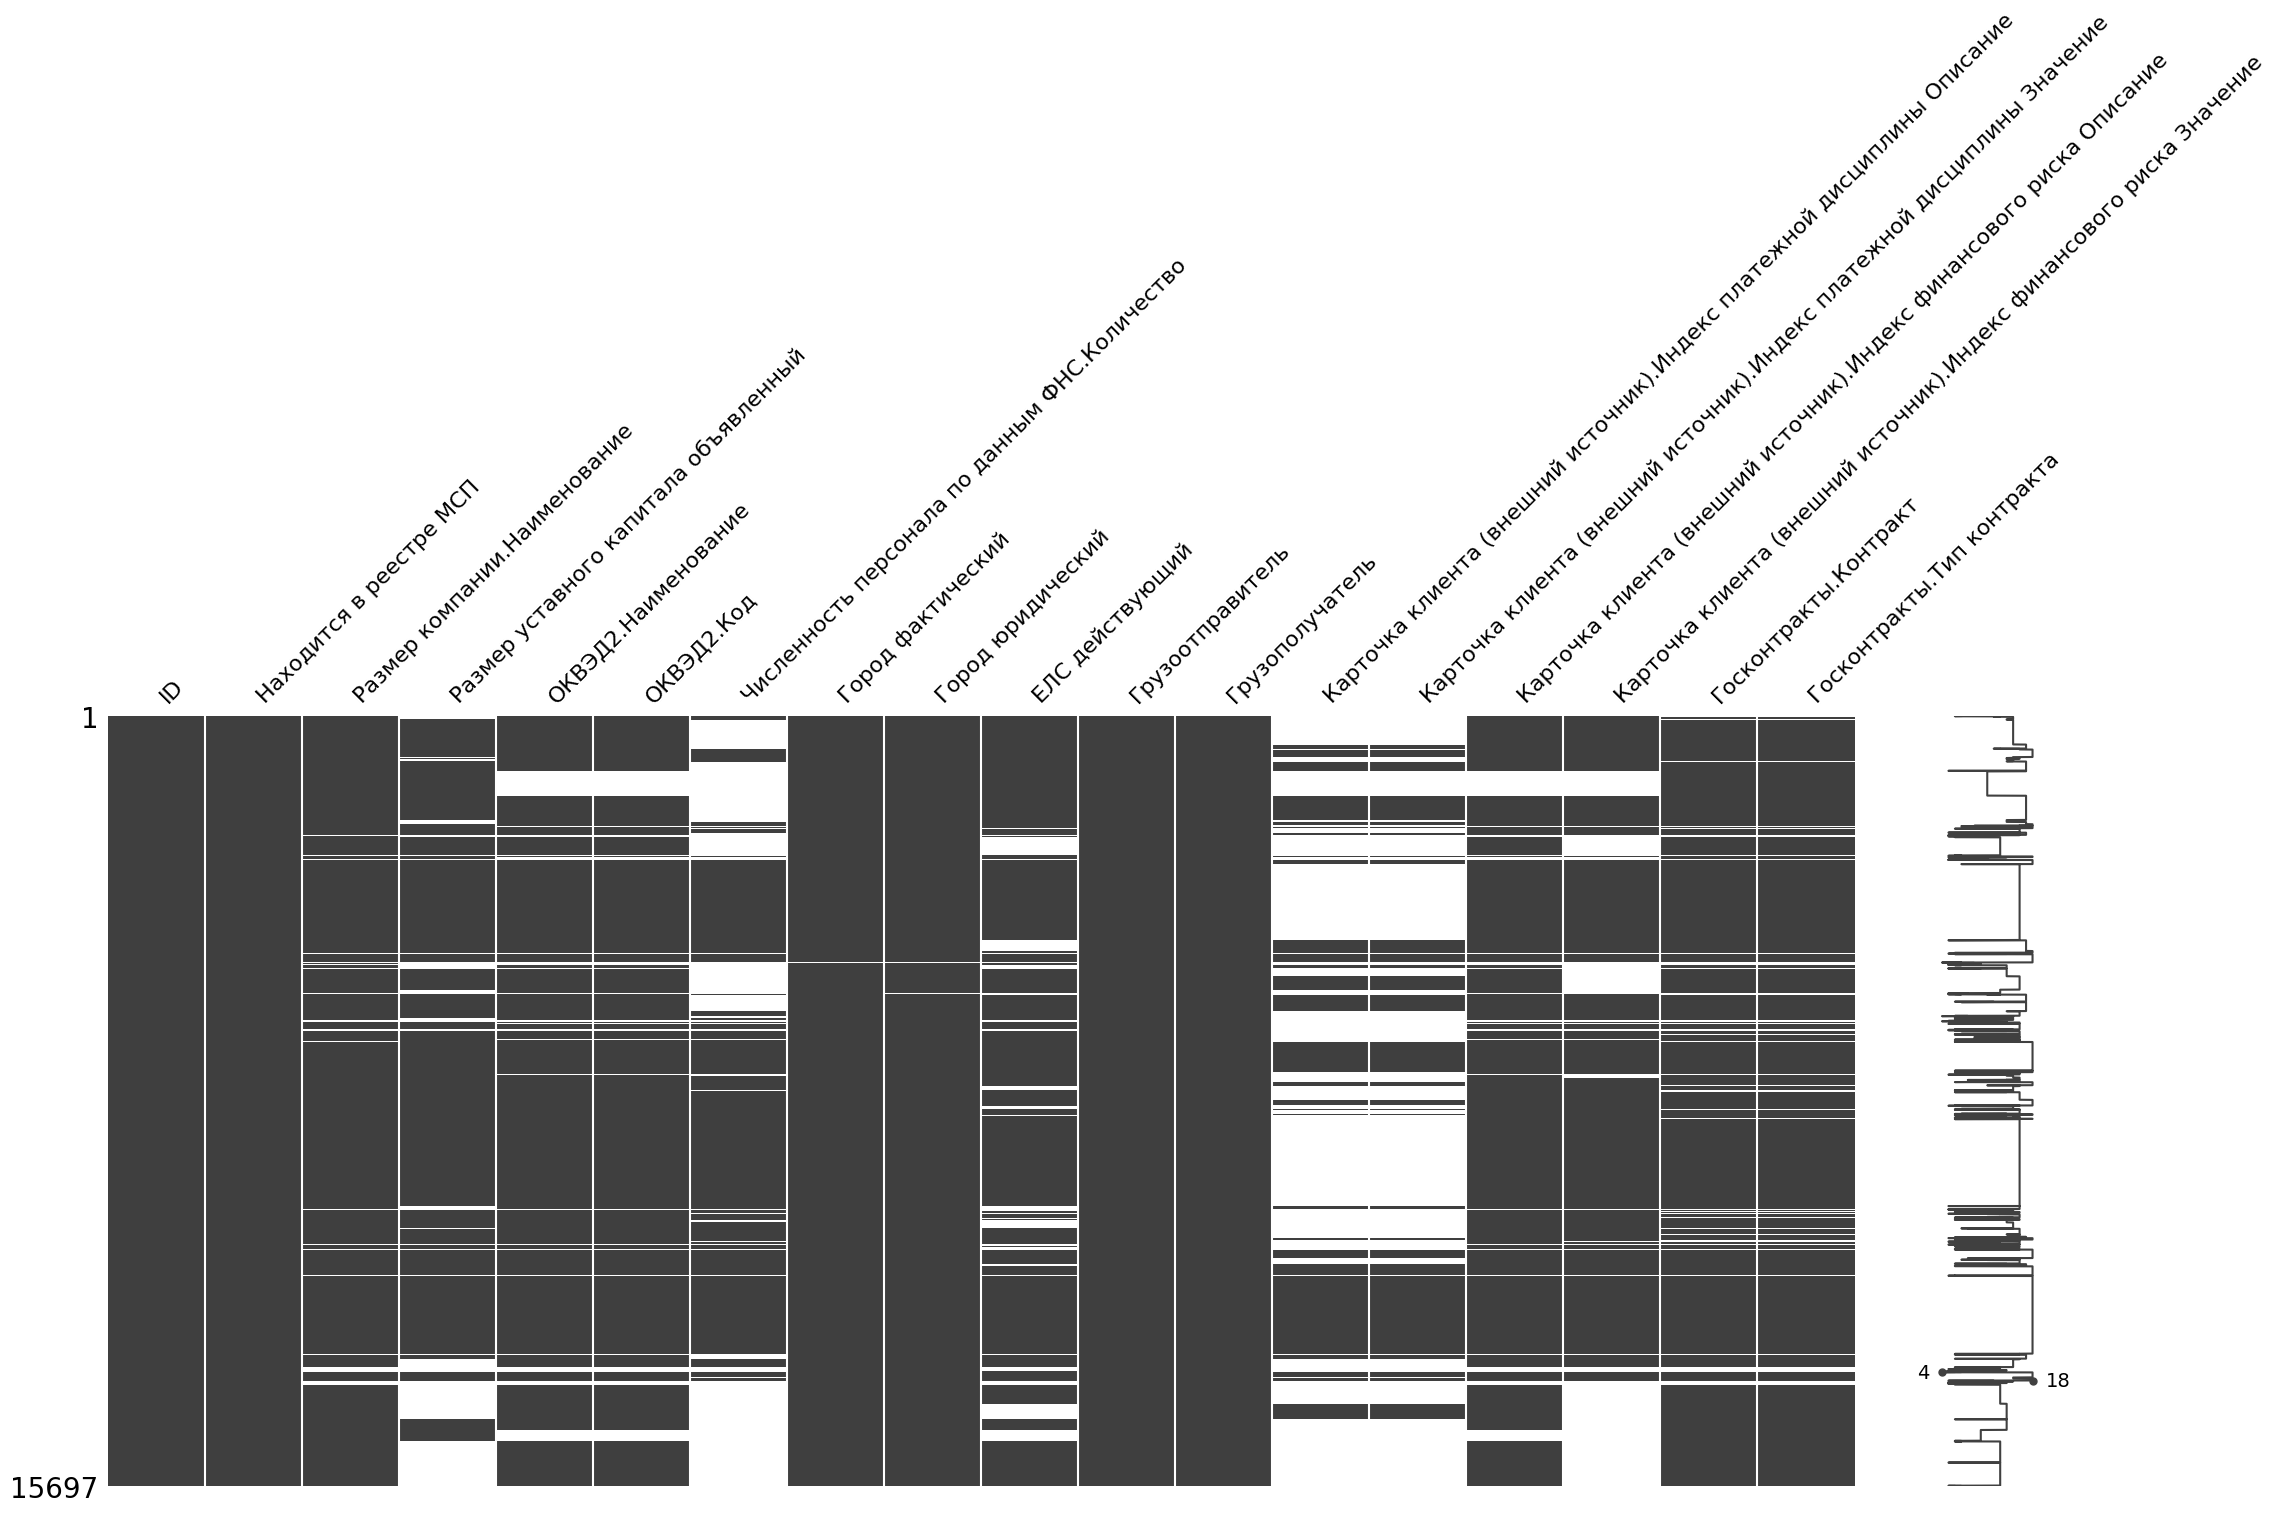

In [6]:
import missingno as msno
msno.matrix(df)

In [8]:
import sweetviz as sv

In [9]:
report = sv.analyze(df)

                                             |                                             | [  0%]   00:00 ->…

In [10]:
report.show_html('report.html')

Report report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Подготовка выборки

(сортировка по наличию ЕЛС действующий)

1) ID
2) Находится в реестре МСП (заменить на 0 или 1)
3) Размер уставного капитала объявленный
4) Численность персонала по данным ФНС.Количество
5) Карточка клиента (внешний источник).Индекс платежной дисциплины Значение - 100 (Низкий риск)
6) Карточка клиента (внешний источник).Индекс финансового риска Значение - 100 (высокий риск)
7) Провозная плата (период 1)
8) Провозная плата (период 2)
9) Объем перевозок(тн) (период 1)
10) Объем перевозок(тн) (период 2)
11) positive_action

## «ЕЛС действующий» – единый лицевой счёт клиента, используемый для оплаты услуг ОАО «РЖД».
Критерий: да/нет («да» – у клиента есть ЕЛС, есть заключенный договоры, сотрудничает с ОАО «РЖД»; «нет» - клиент никогда 
не сотрудничал с ОАО «РЖД», не имеет договорных отношений).


## Все ID связанные с Объёмы_перевозок.xlsx (всего 317 с ЕЛС)

In [32]:
import pandas as pd
import glob

# Читаем данные из файла
file_path = r'Interests_Calls_Volumes_FILTERED\Объёмы_перевозок_periods.xlsx'
df_original = pd.read_excel(file_path)

# Получаем все уникальные значения ID
unique_ids = df_original['ID'].dropna().unique()

# Создаем список для DataFrames всех файлов
dataframes = []

# Проходим по каждому файлу в указанной директории
for file in glob.glob(r"Marketing_Lists\МС_*.xls"):
    df = pd.read_excel(file)
    # Фильтруем строки по уникальным ID
    filtered_df = df[df['ID'].isin(unique_ids)]
    dataframes.append(filtered_df)  # Добавляем отфильтрованные данные в список

# Объединяем все DataFrames в один
if dataframes:  # Только если список не пуст
    combined_df = pd.concat(dataframes, ignore_index=True)
else:
    combined_df = pd.DataFrame()  # Если нет файлов, создаем пустой DataFrame

# Объединяем с оригинальным DataFrame по ID
final_df = pd.merge(df_original, combined_df, on='ID', how='left')

# Сохраняем результат в новый Excel файл
output_path = r'Sample_20_people\МС_Владимирская область_все.xlsx'
final_df.to_excel(output_path, index=False)


In [33]:
# удаление строк, что не вошли в Marketing_Lists
file_path = 'Sample_20_people/МС_Владимирская область_все.xlsx'
df = pd.read_excel(file_path)

df_cleaned = df[df['Находится в реестре МСП'].isin(['Да', 'Нет'])]

df_cleaned.to_excel(r'Sample_20_people\МС_все.xlsx', index=False)


In [37]:
file_path = r'Sample_20_people\МС_все.xlsx'
df = pd.read_excel(file_path)

selected_columns = [
    'ID',
    'Находится в реестре МСП',
    'Размер уставного капитала объявленный',
    'Численность персонала по данным ФНС.Количество',
    'Карточка клиента (внешний источник).Индекс платежной дисциплины Значение',
    'Карточка клиента (внешний источник).Индекс финансового риска Значение',
    'Провозная плата (период 1)',
    'Провозная плата (период 2)',
    'Объем перевозок(тн) (период 1)',
    'Объем перевозок(тн) (период 2)'
]
df_filtered = df[selected_columns]


df_filtered = df_filtered.drop_duplicates(subset='ID', keep='last')


output_path = r'Sample_20_people\filtered_data.xlsx'
df_filtered.to_excel(output_path, index=False)


In [38]:
df = pd.read_excel(r'Sample_20_people\filtered_data.xlsx')
df.head().style

,ID,Находится в реестре МСП,Размер уставного капитала объявленный,Численность персонала по данным ФНС.Количество,Карточка клиента (внешний источник).Индекс платежной дисциплины Значение,Карточка клиента (внешний источник).Индекс финансового риска Значение,Провозная плата (период 1),Провозная плата (период 2),Объем перевозок(тн) (период 1),Объем перевозок(тн) (период 2)
0,9,Нет,nan,18.000000,nan,27.000000,0,168141,0,50
1,25,Нет,nan,361.000000,nan,25.000000,12754399,18211112,31095,34923
2,33,Нет,443485350.000000,1987.000000,84.000000,21.000000,80731499,105789052,28510,31213
3,86,Нет,nan,nan,nan,nan,0,0,0,0
4,115,Нет,20773333.000000,1211.000000,96.000000,16.000000,79490420,113617841,30340,41348


## Расчёт Devotion и Churn

In [58]:
def calculate_client_loyalty(pdi, fri, revenue1, revenue2, volume1, volume2, positiv_action, weights):
    w1, w2, w3, w4, w5 = weights

    pdi_score = pdi
    fri_score = 100 - fri

    revenue_ratio = revenue1 / (revenue1 + revenue2) if (revenue1 + revenue2) > 0 else 0
    volume_ratio = volume1 / (volume1 + volume2) if (volume1 + volume2) > 0 else 0


    positiv_action_score = 10 if positiv_action else 0

    loyalty_percentage = (w1 * pdi_score +
                          w2 * fri_score +
                          w3 * revenue_ratio +
                          w4 * volume_ratio +
                          w5 * positiv_action_score)

    return loyalty_percentage

file_path = r'Sample_20_people\filtered_data_with_positive_action.xlsx'
data = pd.read_excel(file_path)

weights = [0.3, 0.3, 0.1, 0.1, 0.2]  # Веса для расчетов

devotion_scores = []
churn_scores = []

# Рассчитываем Devotion и Churn для каждого клиента
for index, row in data.iterrows():
    pdi = row['Карточка клиента (внешний источник).Индекс платежной дисциплины Значение']
    fri = row['Карточка клиента (внешний источник).Индекс финансового риска Значение']
    revenue1 = row['Провозная плата (период 1)']
    revenue2 = row['Провозная плата (период 2)']
    volume1 = row['Объем перевозок(тн) (период 1)']
    volume2 = row['Объем перевозок(тн) (период 2)']
    positiv_action = row['positive_action']  
    
    # Вычисляем процент верности клиента (Devotion)
    devotion_score = calculate_client_loyalty(pdi, fri, revenue1, revenue2, volume1, volume2, positiv_action, weights)
    
    # Ограничиваем значения Devotion в пределах 1-99
    devotion_score = max(1, min(devotion_score, 99))
    devotion_scores.append(devotion_score)
    
    # Рассчитываем Churn (1, если Devotion > 20; 0 в противном случае)
    churn_score = 1 if devotion_score > 20 else 0
    churn_scores.append(churn_score)

data['Devotion'] = devotion_scores
data['Churn'] = churn_scores

output_file_path = r'Sample_20_people\train20_data.xlsx'
data.to_excel(output_file_path, index=False)

In [60]:
data.head().style

,ID,Находится в реестре МСП,Размер уставного капитала объявленный,Численность персонала по данным ФНС.Количество,Карточка клиента (внешний источник).Индекс платежной дисциплины Значение,Карточка клиента (внешний источник).Индекс финансового риска Значение,Провозная плата (период 1),Провозная плата (период 2),Объем перевозок(тн) (период 1),Объем перевозок(тн) (период 2),positive_action,Devotion,Churn
0,9,Нет,nan,18.000000,nan,27.000000,0,168141,0,50,1,1.000000,0
1,25,Нет,nan,361.000000,nan,25.000000,12754399,18211112,31095,34923,0,1.000000,0
2,33,Нет,443485350.000000,1987.000000,84.000000,21.000000,80731499,105789052,28510,31213,0,48.991020,1
3,86,Нет,nan,nan,nan,nan,0,0,0,0,0,1.000000,0
4,115,Нет,20773333.000000,1211.000000,96.000000,16.000000,79490420,113617841,30340,41348,2,56.083486,1


In [62]:
file_path = r'Sample_20_people\train20_data.xlsx'
df = pd.read_excel(file_path)

# Заполнить пустые ячейки нулями
df.fillna(0, inplace=True)

# Заменить значения в столбце "Находится в реестре МСП"
df['Находится в реестре МСП'] = df['Находится в реестре МСП'].replace({'Нет': 0, 'Да': 1})

df.to_excel(file_path, index=False) 

C:\Temp\ipykernel_3124\2369997025.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Находится в реестре МСП'] = df['Находится в реестре МСП'].replace({'Нет': 0, 'Да': 1})


In [64]:
df.head().style

,ID,Находится в реестре МСП,Размер уставного капитала объявленный,Численность персонала по данным ФНС.Количество,Карточка клиента (внешний источник).Индекс платежной дисциплины Значение,Карточка клиента (внешний источник).Индекс финансового риска Значение,Провозная плата (период 1),Провозная плата (период 2),Объем перевозок(тн) (период 1),Объем перевозок(тн) (период 2),positive_action,Devotion,Churn
0,9,0,0,18,0,27,0,168141,0,50,1,1.000000,0
1,25,0,0,361,0,25,12754399,18211112,31095,34923,0,1.000000,0
2,33,0,443485350,1987,84,21,80731499,105789052,28510,31213,0,48.991020,1
3,86,0,0,0,0,0,0,0,0,0,0,1.000000,0
4,115,0,20773333,1211,96,16,79490420,113617841,30340,41348,2,56.083486,1
